In [60]:
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure

from sklearn import ensemble
import cv2

import pickle
import time

In [69]:
%matplotlib inline

In [21]:
image = color.rgb2gray(data.astronaut())
print image.shape
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

(512, 512)


In [106]:
def hog_data_gen(orientations, pixels_per_cell, cells_per_block):
    
    print "orientations =",orientations,"pixels_per_cell =",pixels_per_cell,"cells_per_block =",cells_per_block

    X_train_label = pickle.load(open("X_train_label", 'rb'))
    X_test_label = pickle.load(open("X_test_label", 'rb'))
    
    y_train = pickle.load(open("y_train", 'rb'))
    y_test = pickle.load(open("y_test", 'rb'))
    
    # load actual image binary according to label lists 
    # training set
    X_train = []
    for i in range(5):
        for name in X_train_label[i]:
            tmp = cv2.imread("../../train256/"+name+".jpeg")
            tmp = cv2.resize(tmp, (256,171))
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
            tmp = hog(tmp, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
            X_train.append(tmp.tolist())
            """
            if X_train is np.nan:
                X_train = tmp
            else:
                X_train = np.concatenate((X_train, tmp), axis=0)
            """
    X_train = np.array(X_train)
    
    # test set
    X_test = []
    for i in range(5):
        for name in X_test_label[i]:
            tmp = cv2.imread("../../train256/"+name+".jpeg")
            tmp = cv2.resize(tmp, (256,171))
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
            tmp = hog(tmp, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
            X_test.append(tmp.tolist())
            
            """
            if X_test is np.nan:
                X_test = tmp
            else:
                X_test = np.concatenate((X_test, tmp), axis=0)
            """
    X_test = np.array(X_test)
    
    return X_train,y_train,X_test,y_test

In [109]:
def raw_data_gen():

    X_train = pickle.load(open("X_train", 'rb'))
    X_test = pickle.load(open("X_test", 'rb'))
    
    y_train = pickle.load(open("y_train", 'rb'))
    y_test = pickle.load(open("y_test", 'rb'))
    
    return X_train,y_train,X_test,y_test

In [103]:
def random_forest_test(n_estimators, criterion, max_depth, X_train, y_train, X_test, y_test):
    rf = ensemble.RandomForestClassifier(n_estimators = n_estimators, criterion=criterion, max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    test_score = rf.score(X_test, y_test)
    train_score = rf.score(X_train, y_train)
    print "n_estimators =",n_estimators,"criterion =",criterion,"max_depth =",max_depth,"test_score =",test_score,"train_score =",train_score
    return test_score, train_score

In [104]:
t = time.time()
X_train,y_train,X_test,y_test = hog_data_gen(9, (8,8), (2,2))
print time.time() - t

59.2787280083


In [113]:

orientations = [8]
cells = [(32,32), (16,16), (8,8)]
blocks = [(1,1), (2,2), (3,3), (4,4)]
test_result = dict()
train_result = dict()
n_estimators = [10, 50, 100, 200, 500, 750]
criterion = ["gini", "entropy"]
max_depth = [5, 6, 7, 8, 9, 10]
for o in orientations:
    for cell in cells:
        for b in blocks:
            X_train,y_train,X_test,y_test = hog_data_gen(o, cell, b)
            for n in n_estimators:
                for c in criterion:
                    for d in max_depth:
                        test_score, train_score = random_forest_test(n, c, d, X_train, y_train, X_test, y_test)
                        test_result[(o,cell,b,n,c,d)] = test_score
                        train_result[(o,cell,b,n,c,d)] = train_score
            print ""

orientations = 8 pixels_per_cell = (32, 32) cells_per_block = (1, 1)
n_estimators = 10 criterion = gini max_depth = 5 test_score = 0.252 train_score = 0.603
n_estimators = 10 criterion = gini max_depth = 6 test_score = 0.257 train_score = 0.698
n_estimators = 10 criterion = gini max_depth = 7 test_score = 0.272 train_score = 0.784
n_estimators = 10 criterion = gini max_depth = 8 test_score = 0.258 train_score = 0.829
n_estimators = 10 criterion = gini max_depth = 9 test_score = 0.254 train_score = 0.897
n_estimators = 10 criterion = gini max_depth = 10 test_score = 0.24 train_score = 0.946
n_estimators = 10 criterion = entropy max_depth = 5 test_score = 0.28 train_score = 0.645
n_estimators = 10 criterion = entropy max_depth = 6 test_score = 0.234 train_score = 0.722
n_estimators = 10 criterion = entropy max_depth = 7 test_score = 0.24 train_score = 0.803
n_estimators = 10 criterion = entropy max_depth = 8 test_score = 0.244 train_score = 0.904
n_estimators = 10 criterion = entropy max

In [114]:
pickle.dump(test_result, open("test_result_hog", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(train_result, open("train_result_hog", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [117]:
max(test_result.items(), key = lambda d:d[1])

((8, (16, 16), (3, 3), 750, 'entropy', 10), 0.31900000000000001)

In [105]:
random_forest_test(500, "gini", 7, X_train, y_train, X_test, y_test)

n_estimators = 500 criterion = gini max_depth = 7 test_score = 0.273 train_score = 1.0


(0.27300000000000002, 1.0)

In [118]:
X_train,y_train,X_test,y_test = raw_data_gen()

test_result = dict()
train_result = dict()
n_estimators = [10, 50, 100, 200, 500, 750]
criterion = ["gini", "entropy"]
#max_depth = [5, 6, 7, 8, 9, 10]
max_depth = [2, 3, 4]

for n in n_estimators:
    for c in criterion:
        for d in max_depth:
            test_score, train_score = random_forest_test(n, c, d, X_train, y_train, X_test, y_test)
            test_result[(n,c,d)] = test_score
            train_result[(n,c,d)] = train_score

n_estimators = 10 criterion = gini max_depth = 2 test_score = 0.234 train_score = 0.356
n_estimators = 10 criterion = gini max_depth = 3 test_score = 0.247 train_score = 0.41
n_estimators = 10 criterion = gini max_depth = 4 test_score = 0.252 train_score = 0.535
n_estimators = 10 criterion = entropy max_depth = 2 test_score = 0.271 train_score = 0.353
n_estimators = 10 criterion = entropy max_depth = 3 test_score = 0.233 train_score = 0.448
n_estimators = 10 criterion = entropy max_depth = 4 test_score = 0.258 train_score = 0.514
n_estimators = 50 criterion = gini max_depth = 2 test_score = 0.269 train_score = 0.401
n_estimators = 50 criterion = gini max_depth = 3 test_score = 0.259 train_score = 0.488
n_estimators = 50 criterion = gini max_depth = 4 test_score = 0.263 train_score = 0.587
n_estimators = 50 criterion = entropy max_depth = 2 test_score = 0.263 train_score = 0.376
n_estimators = 50 criterion = entropy max_depth = 3 test_score = 0.26 train_score = 0.49
n_estimators = 50 cr

In [119]:
max(test_result.items(), key = lambda d: d[1])

((200, 'entropy', 4), 0.27800000000000002)

In [112]:
pickle.dump(test_result, open("test_result_raw", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(train_result, open("train_result_raw", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

(128, 522)
(66816,)
(171, 256)
0.153131008148


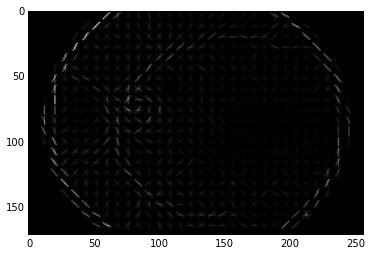

In [134]:
start = time.time()
img = cv2.imread("../../train256/37569_left.jpeg")
img = cv2.resize(img, (256,171))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print img.shape
#img = hog(img)
img,hog_img = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(4, 4), visualise=True)
#img = local_contrast_enhancement(img, 50, 179, 30)
#img = flood_fill_hls(img, 0.8)
print img.reshape((int(img.shape[0]/(8*16)), 8*16)).T.shape
print img.shape
print hog_img.shape
print time.time() - start
plt.imshow(hog_img, cmap=plt.cm.gray)
plt.show()

(6048,)
(171, 256)
0.177891016006


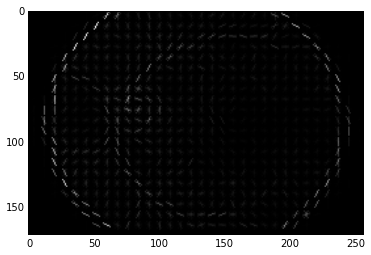

In [72]:
start = time.time()
img = cv2.imread("../../train256/37569_left.jpeg")
img = cv2.resize(img, (256,171))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print img.shape
#img = hog(img)
img,hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualise=True)
#img = local_contrast_enhancement(img, 50, 179, 30)
#img = flood_fill_hls(img, 0.8)
#img.reshape((1, 171*256*3))
print img.shape
print hog_img.shape
print time.time() - start
plt.imshow(hog_img, cmap=plt.cm.gray)
plt.show()

In [73]:
22320/9

2480.0

In [77]:
img1 = cv2.imread("../../train256/37569_left.jpeg")
img2 = cv2.imread("../../train256/37569_left.jpeg")

In [82]:
img1 = img1.reshape((192*256*3))
img2 = img2.reshape((192*256*3))

In [133]:
np.array([1,2,3,4,5,6,2,3,4,5,6,7]).reshape((2,6))

array([[1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7]])

In [136]:
a = np.zeros((0, 128), dtype = 'uint8')